In [1]:
%matplotlib inline

import numpy as np
import numpy.random as npr
import math
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from rlbase.environment import BanditEnvironment
from rlbase.policy import EpsGreedy, Softmax
from rlbase.agent import SimpleAgent, GradientAgent

In [2]:
def plot_results(results, optimal_actions):
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(2,1,1)
    for k in results.keys():
      plt.plot(results[k])
    plt.legend(results.keys())
    plt.subplot(2,1,2)
    for k in optimal_actions.keys():
      plt.plot(optimal_actions[k])
    plt.legend(optimal_actions.keys())
    plt.show()

# Figure 2.2
Average performance of $\epsilon$-greedy action-value methods on the 10-armed testbed. These data are averages over 2000 runs with different bandit problems. All methods used sample averages as their action-value estimates.

100%|██████████| 2000/2000 [01:25<00:00, 23.48it/s]


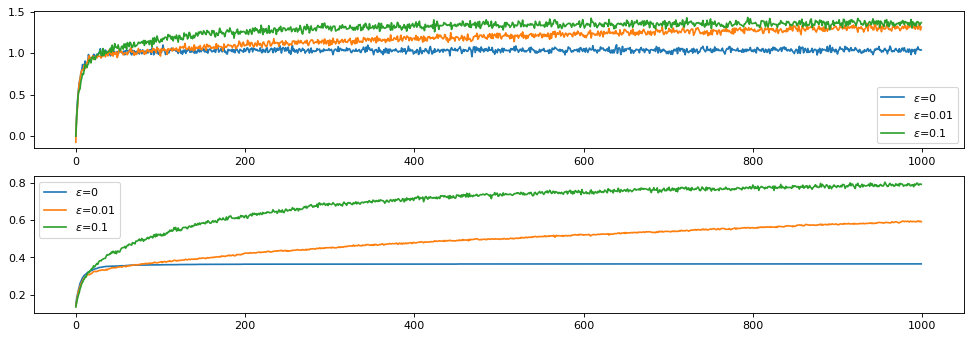

In [3]:
N_timesteps = 1000
N_bandits = 2000

agent_infos = {"$\epsilon$=0":{"eps":0},
               "$\epsilon$=0.01":{"eps":0.01},
               "$\epsilon$=0.1":{"eps":0.1}}

results         = {i:[0]*N_timesteps for i in agent_infos}
optimal_actions = {i:[0]*N_timesteps for i in agent_infos}
for bandit in tqdm(range(N_bandits)):
  env = BanditEnvironment()
  for (k,v) in agent_infos.items():
    pi = EpsGreedy(env=env, **v)
    agent = SimpleAgent(env=env, pi=pi)  
    
    best_action = list(env.arms).index(max(env.arms))
    s = env.start()
    a = agent.start(s)
    for t in range(N_timesteps):
      r, s, _ = env.step(s,a)
      a = agent.step(r,s)
      results[k][t] += r / N_bandits
      optimal_actions[k][t] += (a==best_action) / N_bandits
plot_results(results, optimal_actions)

# Exercise 2.5
Demonstrate the difficulties that sample-average methods have for nonstationary problems.

100%|██████████| 1000/1000 [09:09<00:00,  1.82it/s]


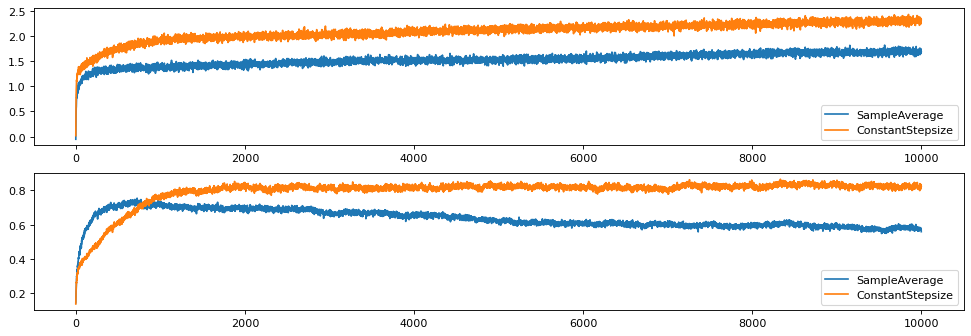

In [4]:
N_timesteps = 10000
N_bandits = 1000

agent_infos = {"SampleAverage":{"eps":0.1},
               "ConstantStepsize":{"eps":0.1,"alpha":0.1}}

results         = {i:[0]*N_timesteps for i in agent_infos}
optimal_actions = {i:[0]*N_timesteps for i in agent_infos}
for bandit in tqdm(range(N_bandits)):
  env = BanditEnvironment(random=True)
  for (k,v) in agent_infos.items():
    pi = EpsGreedy(env=env, **v)
    agent = SimpleAgent(env=env,pi=pi,**v)
    s = env.start()
    a = agent.start(s)
    for t in range(N_timesteps):
      best_action = list(env.arms).index(max(env.arms))
      r, s, _ = env.step(s,a)
      a = agent.step(r,s)
      results[k][t] += r / N_bandits
      optimal_actions[k][t] += (a==best_action) / N_bandits
plot_results(results, optimal_actions)

# Figure 2.3
The effect of optimistic initial action-value estimates on the 10-armed testbed. Both methods use a constant step-size parameter, $\alpha=0.1$.

100%|██████████| 1000/1000 [00:23<00:00, 42.28it/s]


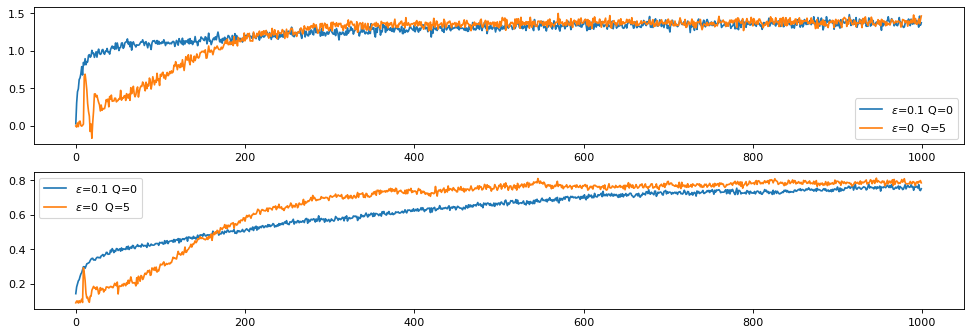

In [5]:
N_timesteps = 1000
N_bandits = 1000

agent_infos = {"$\epsilon$=0.1 Q=0":{"eps":0.1},
               "$\epsilon$=0  Q=5":{"eps":0,"q_init":5}}

results         = {i:[0]*N_timesteps for i in agent_infos}
optimal_actions = {i:[0]*N_timesteps for i in agent_infos}
for bandit in tqdm(range(N_bandits)):
  env = BanditEnvironment()
  for (k,v) in agent_infos.items():
    pi = EpsGreedy(env=env,eps=0.1)
    agent = SimpleAgent(env=env,pi=pi,alpha=0.1,**v)
    s = env.start()
    a = agent.start(s)
    best_action = list(env.arms).index(max(env.arms))
    for t in range(N_timesteps):
      r, s, _ = env.step(s,a)
      a = agent.step(r,s)
      results[k][t] += r / N_bandits
      optimal_actions[k][t] += (a==best_action) / N_bandits
plot_results(results, optimal_actions)

# Figure 2.4
Average performance of UCB action selection on the 10-armed testbed. As shown, UCB generally performs better than $\epsilon$-greedy action selection, except in the first $k$ steps, when it selects randomly among the as-yet-untried actions.

100%|██████████| 1000/1000 [00:31<00:00, 31.93it/s]


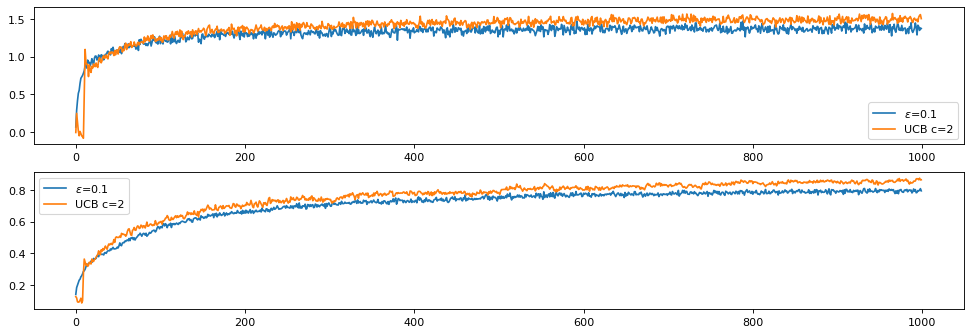

In [6]:
N_timesteps = 1000
N_bandits = 1000

agent_infos = {"$\epsilon$=0.1":{"eps":0.1},
               "UCB c=2":{"eps":0,"ucb_c":2}}

results         = {i:[0]*N_timesteps for i in agent_infos}
optimal_actions = {i:[0]*N_timesteps for i in agent_infos}
for bandit in tqdm(range(N_bandits)):
  env = BanditEnvironment()
  for (k,v) in agent_infos.items():
    pi = EpsGreedy(env=env,**v)
    agent = SimpleAgent(env=env,pi=pi,**v)
    s = env.start()
    a = agent.start(s)
    best_action = list(env.arms).index(max(env.arms))
    for t in range(N_timesteps):
      r, s, _ = env.step(s,a)
      a = agent.step(r,s)
      results[k][t] += r / N_bandits
      optimal_actions[k][t] += (a==best_action) / N_bandits
plot_results(results, optimal_actions)

# Figure 2.5
Average performance of the gradient bandit algorithm with and without a reward baseline on the 10-armed testbed when the $q_*(a)$ are chosen to be near $+4$ rather than near zero.

100%|██████████| 1000/1000 [05:21<00:00,  3.11it/s]


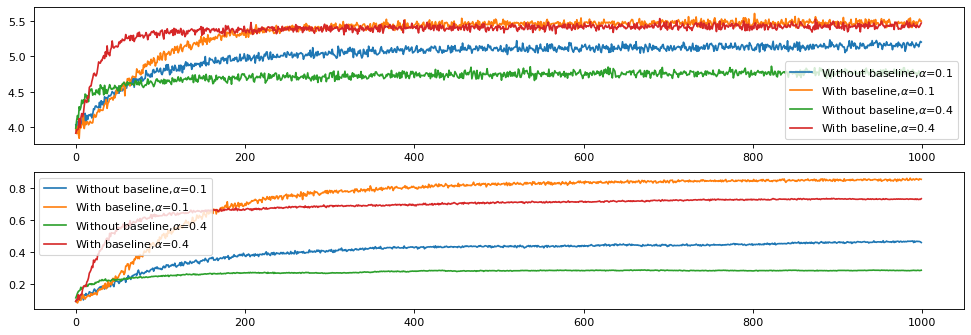

In [7]:
N_timesteps = 1000
N_bandits = 1000

agent_infos = {r"Without baseline,$\alpha$=0.1":{"baseline":False,"alpha":0.1},
               r"With baseline,$\alpha$=0.1":{"baseline":True,"alpha":0.1},
               r"Without baseline,$\alpha$=0.4":{"baseline":False,"alpha":0.4},
               r"With baseline,$\alpha$=0.4":{"baseline":True,"alpha":0.4}}

results         = {i:[0]*N_timesteps for i in agent_infos}
optimal_actions = {i:[0]*N_timesteps for i in agent_infos}
for bandit in tqdm(range(N_bandits)):
  env = BanditEnvironment(offset=4)
  for (k,v) in agent_infos.items():
    pi = Softmax(env=env)
    agent = GradientAgent(env=env,pi=pi,**v)
    s = env.start()
    a = agent.start(s)
    best_action = list(env.arms).index(max(env.arms))
    for t in range(N_timesteps):
      r, s, _ = env.step(s,a)
      a = agent.step(r,s)
      results[k][t] += r / N_bandits
      optimal_actions[k][t] += (a==best_action) / N_bandits
plot_results(results, optimal_actions)

# Figure 2.6
A parameter study of the various bandit algorithms presented in this chapter. Each point is the average reward obtained over 1000 steps with a particular algorithm at a particular setting of its parameter

100%|██████████| 1000/1000 [27:56<00:00,  1.68s/it]


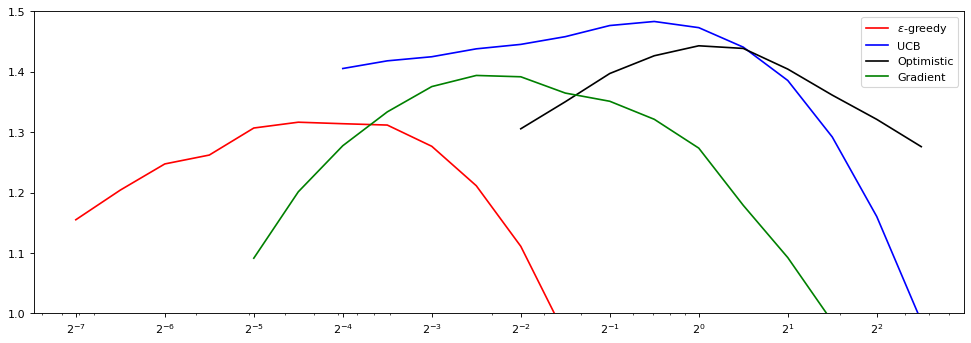

In [8]:
N_timesteps = 1000
N_bandits = 1000

agent_infos = {}
results = {}
algos = ["$\epsilon$-greedy","UCB","Optimistic","Gradient"]
lower = [-7,-4,-2,-5]
upper = [-1,3,3,3]
for (algo,low,up) in zip(algos,lower,upper):
    paras = np.power(2.,np.arange(low,up,.5))
    agent_infos[algo] = paras
    results[algo] = {p:0 for p in paras}
    optimal_actions[algo] = {p:0 for p in paras}

for bandit in tqdm(range(N_bandits)):
  env = BanditEnvironment()
  for (algo,paras) in agent_infos.items():
    for para in paras:
        if algo == "$\epsilon$-greedy":
            pi = EpsGreedy(env=env,eps=para)
            agent = SimpleAgent(env=env,pi=pi) 
        elif algo == "UCB":
            pi = EpsGreedy(env=env,eps=0)
            agent = SimpleAgent(env=env,pi=pi,ucb_c=para)       
        elif algo == "Optimistic":
            pi = EpsGreedy(env=env,eps=0)
            agent = SimpleAgent(env=env,pi=pi,q_init=para,alpha=0.1)       
        elif algo == "Gradient":
            pi = Softmax(env=env)
            agent = GradientAgent(env=env,pi=pi,alpha=para)
        s = env.start()
        a = agent.start(s)
        best_action = list(env.arms).index(max(env.arms))
        for t in range(N_timesteps):
          r, s, _ = env.step(s,a)
          a = agent.step(r,s)
          results[algo][para] += r
          optimal_actions[algo][para] += (a==best_action)
            
colors = ["r","b","k","g"]
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
for (algo,color) in zip(algos,colors):
    x = [i for i in results[algo].keys()]
    y = [v/N_bandits/N_timesteps for v in results[algo].values()]
    plt.semilogx(x,y,color)
plt.legend(results.keys())

exps = np.arange(-7,3)
xticks = np.power(2.,exps)
labels = [r"$2^{"+str(e)+"}$" for e in exps]

plt.xticks(xticks,labels)
plt.ylim(1,1.5)
plt.show()